# AOS DM-47413 Making mosaic images

Owner: **Chris  Suberlak** [@suberlak](https://github.com/lsst-ts/ts_aos_analysis/issues/new?body=@suberlak) <br>
Last Verified to Run: **2024-11-05** <br>
Software Versions:
  - `lsst_distrib`: **w_2024_43**

## Setup:

This notebook was run on https://usdf-rsp.slac.stanford.edu/ .


## Imports

In [1]:
import os 
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
import numpy as np
import lsst.afw.math as afwMath
from lsst.afw.cameraGeom import utils as cgu
import lsst.afw.display as afwDisplay
from lsst.obs.lsst import LsstComCam

## Make a mosaic plot

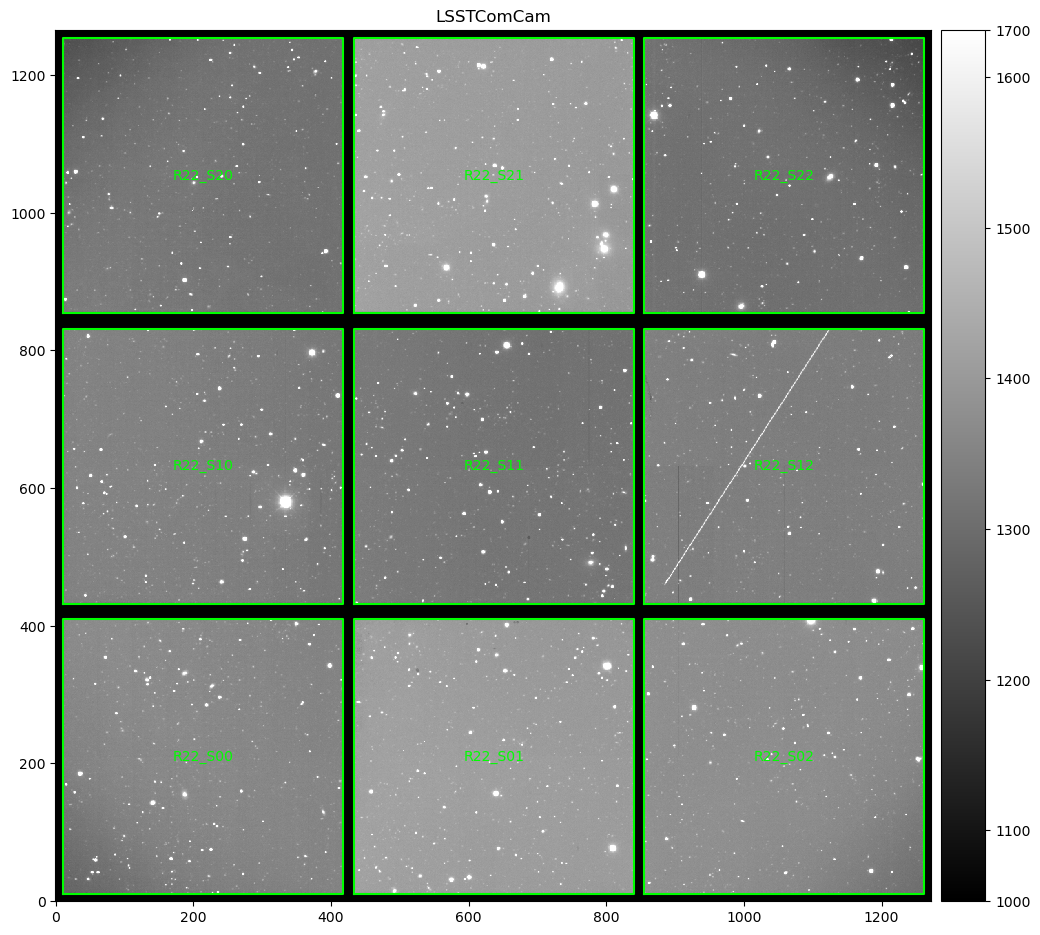

In [3]:
# Based on  https://lsstc.slack.com/archives/CHXKSF3HC/p1687390733400369
# and https://lsstc.slack.com/archives/C2JPL2DGD/p1725651458046529

class UserImageSource:
    isTrimmed = True
    background = 0.0

    def __init__(self, butler, exposure_refs):
        self.butler = butler
        self.exposure_refs = exposure_refs

    def getCcdImage(self, det, imageFactory, binSize=1, *args, **kwargs):
        ccdImage = self.butler.get(self.exposure_refs[det.getId()]).getImage()
        ccdImage = afwMath.binImage(ccdImage, binSize)
        return afwMath.rotateImageBy90(ccdImage,
                                       det.getOrientation().getNQuarter()), det


def make_mosaic(butler, exposure_refs, camera, binSize, disp ):
    detectorNameList = [camera[detector].getName() for
                        detector in exposure_refs]
    image_source = UserImageSource(butler, exposure_refs)
    return cgu.showCamera(camera, imageSource=image_source,
                          detectorNameList=detectorNameList,
                          binSize=binSize, overlay=True,
                         display=disp)

camera = LsstComCam.getCamera()

binSize=10 # sets the window width for binning

repo = 'embargo_new'
collection = 'LSSTComCam/nightlyValidation'
butler = Butler(repo, collections=[collection])

dayObs = 20241031 
seqNum = 36 

dataRefs = list(butler.registry.queryDatasets('postISRCCD', where=f"instrument='LSSTComCam' \
and day_obs = {dayObs} and exposure.seq_num = {seqNum}").expanded())

# Any other subset of detectors can be plotted as well
exposure_refs = {ref.dataId['detector']: ref for ref in dataRefs}


fig = plt.figure(figsize=(12,12))
disp = afwDisplay.Display(1, "matplotlib")
disp.scale('linear', min='zscale') # scale needs to be set before calling make_mosaic()
mosaic = make_mosaic(butler, exposure_refs, camera, binSize, disp)